In [14]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
dataset_path = '/content/drive/My Drive/mhealth_balanced_preprocessed.csv'
data = pd.read_csv(dataset_path)
data.head()

<ipython-input-22-4861e52ff204>:7: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


,chest_acc_x,chest_acc_y,chest_acc_z,ecg_1,ecg_2,ankle_acc_x,ankle_acc_y,ankle_acc_z,ankle_gyro_x,ankle_gyro_y,...,arm_acc_x,arm_acc_y,arm_acc_z,arm_gyro_x,arm_gyro_y,arm_gyro_z,arm_mag_x,arm_mag_y,arm_mag_z,label
0,-0.082298,0.100707,-0.109697,-0.040645,0.012529,-0.318837,0.209841,0.381243,-0.626800,-0.331064,...,0.308429,-0.396686,-0.247928,-1.055188,-0.385007,-0.283994,0.030973,-0.085350,-0.009639,standing_sitting
1,-0.145185,-0.058681,0.080943,0.029537,0.028832,-0.186470,0.240070,0.443979,0.477669,-0.021467,...,0.434662,-0.381911,0.396716,0.814344,-0.407283,1.095761,0.042972,-0.075806,0.002653,standing_sitting
2,-0.079641,-0.191486,0.010085,0.141002,0.138880,-0.160918,0.264784,0.482819,0.498755,0.066031,...,0.443040,-0.372538,0.383792,0.850914,-0.389458,1.118194,0.027122,-0.071250,-0.006657,standing_sitting
3,-0.131824,0.024539,0.401956,2.163932,0.974429,-0.423189,0.234660,0.427225,-1.208550,-0.021467,...,0.329354,-0.390973,0.021780,-1.009473,-0.402832,-0.340085,0.035511,-0.019771,0.005469,standing_sitting
4,-0.126107,0.260801,0.649338,-0.048902,0.053287,-0.267000,0.247715,0.370905,1.228038,-0.203171,...,0.247260,-0.317893,0.265003,1.093174,-0.656953,0.991055,0.022950,-0.094383,-0.003555,standing_sitting


In [24]:
from sklearn.preprocessing import LabelEncoder

data["label"] = data["label"].astype(str)

X = data.drop(columns=["label"]).values
y = data["label"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mappings:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Features shape:", X.shape)
print("Labels shape:", y_encoded.shape)

Label mappings: {'0': 0, 'jogging': 1, 'running': 2, 'standing_sitting': 3, 'walking': 4}
Features shape: (153600, 23)
Labels shape: (153600,)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (107520, 23) (107520,)
Validation set shape: (23040, 23) (23040,)
Test set shape: (23040, 23) (23040,)


In [26]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("LSTM input shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


LSTM input shapes:
X_train: (107520, 1, 23)
X_val: (23040, 1, 23)
X_test: (23040, 1, 23)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 128)              │          77,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,477 (505.77 KB)

 Trainable params: 129,477 (505.77 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.7837 - loss: 0.5786 - val_accuracy: 0.9388 - val_loss: 0.1835
Epoch 2/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9295 - loss: 0.2098 - val_accuracy: 0.9542 - val_loss: 0.1411
Epoch 3/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9454 - loss: 0.1703 - val_accuracy: 0.9647 - val_loss: 0.1187
Epoch 4/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9549 - loss: 0.1487 - val_accuracy: 0.9656 - val_loss: 0.1171
Epoch 5/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9586 - loss: 0.1344 - val_accuracy: 0.9707 - val_loss: 0.1038
Epoch 6/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9623 - loss: 0.1263 - val_accuracy: 0.9697 - val_loss: 0.1055
Epoch 7/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9642 - loss: 0.1204 - val_accuracy: 0.9699 - val_loss: 0.1059
Epoch 8/20
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9663 - loss: 0

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.07742559909820557
Test Accuracy: 0.9798176884651184


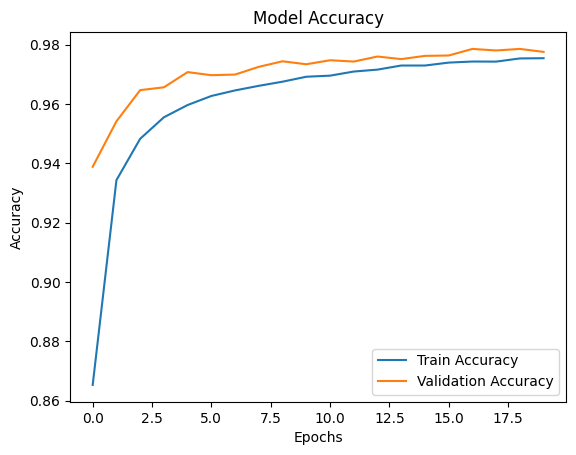

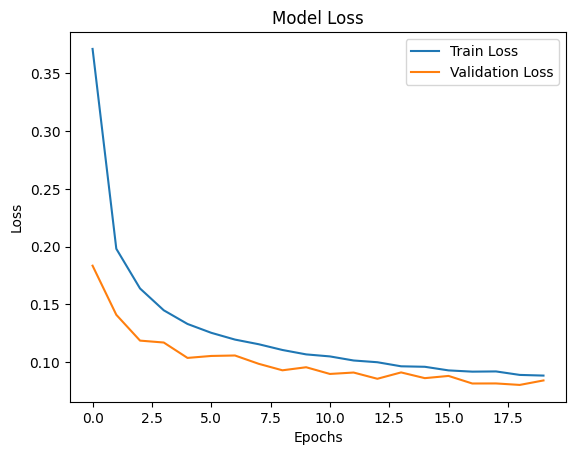

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


720/720 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
                  precision    recall  f1-score   support

               0       1.00      0.93      0.96      4608
         jogging       0.97      0.99      0.98      4608
         running       0.97      0.99      0.98      4608
standing_sitting       0.98      1.00      0.99      4608
         walking       0.97      1.00      0.99      4608

        accuracy                           0.98     23040
       macro avg       0.98      0.98      0.98     23040
    weighted avg       0.98      0.98      0.98     23040

